In [2]:
import numpy as np
import pandas as pd
import math
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%precision 4

'%.4f'

1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

Text(0.5, 0, 'Time')

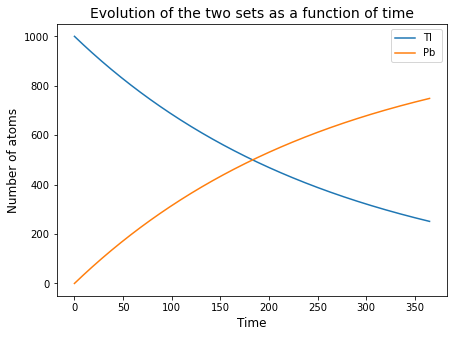

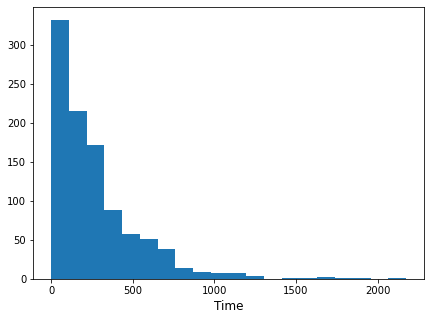

In [10]:
#code ex1
    
#Radioactive decay chain
tau_tl=3.052*60 #sec
tl0=1000

def prob(t,tau):
    return 1-2**(-t/tau)

pb=[]
tl=[]

for i in range(0,int(tau_tl*2)) :
    tl.append(tl0*np.abs((prob(i,tau_tl)-1)))
    
for i in range(0,int(tau_tl)*2) :
    pb.append(tl0*prob(i,tau_tl))
    
#Plot the evolution of the two sets as a function of time 
f, ax1 = plt.subplots(1,1, figsize=(7,5))

time=np.arange(int(tau_tl)*2)
ax1.plot(time,tl, label="Tl")
ax1.plot(time,pb, label="Pb ")
ax1.set_title("Evolution of the two sets as a function of time" ,fontsize=14)
ax1.set_ylabel("Number of atoms",fontsize=12)
ax1.set_xlabel("Time",fontsize=12)
ax1.legend()


#Repeat the exercise by means of the inverse transform method: draw 1000 random numbers 
#from the non-uniform probability distribution 𝑝(𝑡)=2−𝑡/𝜏ln2𝜏 
#to represent the times of decay of the 1000 Tl atoms. 

tau=3.052*60 #sec
tl0=1000
r=[]

z=np.random.random(tl0)
z=np.flip(np.sort(z))

def nonunif(z):
    return (-tau/np.log(2))*np.log(1-z)

r=nonunif(z)

f, ax3 = plt.subplots(1,1, figsize=(7,5))
ax3.hist(r, 20)
ax3.set_xlabel("Time",fontsize=12)



2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

In [7]:
#code ex2
Z = 79
e = 1.6e-19
eps0 = 8.854e-12
E = (7.7e6)*(1.6e-19)
a0 = 5.29e-11 
N = 1000000 #assume 1 million alpha particle are shot on the gold atom 
sigma = a0/100

#beam 2D gaussian gistribution 
x=np.random.normal(0,sigma, N)
y=np.random.normal(0,sigma, N)

#b parameter
b=np.sqrt(x**2+y**2)

#scattering angle
angle=2*np.arctan((Z*e**2)/(2*math.pi*eps0*E*b))

#Fraction of particles that "bounce back", particle whose scattering angle is greater than 𝜋/2 
particle_back= angle[angle>math.pi/2]
print("Fraction of particles that bounce back: ", len(particle_back)/N)



Fraction of particles that bounce back:  0.001626


3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

In [24]:
#code ex3

def f(x):
    return (np.sin(1/(x*(2-x))))**2


##Compute the integral of 𝑓(𝑥) between 0 and 2 with the hit/miss method 

# Monte Carlo integration
N=100000
count=0
for i in range(N):
    x=2*np.random.random()  #random number btw (0,1)*2=(0,2)
    y=np.random.random() 
    if y<f(x): count+=1
I=2*count/N
print("Integral with the hit/miss method:{:0.5f}".format(I))

#Evaluate the error of your estimate
#---


##Repeat the integral with the mean value method
X=2*np.random.uniform(size=N) #sizeN to solve errore of type float
a=0
b=2
integ = ((b-a)/N)*sum(f(X))
print("Integral with the mean value method:{:0.5f}".format(integ))

#Evaluate the error and compare it with the previous one
var=np.var(f(X))
err=2*np.sqrt(var)/np.sqrt(N)   
print("Error: {:0.5f}".format(err))



Integral with the hit/miss method:1.45312
Integral with the mean value method:1.45225
Error: 0.00166


4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



In [19]:
#code ex4

#Compute the area of a circle of unit radius, by integrating the function

def f(x,y):
    func=x**2+y**2
    return func[:] < 1
    
N=100000
x=np.random.uniform(-1,1,size=N)
y=np.random.uniform(-1,1,size=N)
a,b= 0,1

#area of a circle of unit radius
area=4*((b-a)/N)*sum(np.sqrt(f(x,y)))
print("Area of the circle of unit radius:{:0.3f}".format(area))


#Generalize the result for a 10D sphere
def f_dim(dim):
    func = 0
    for i in range(dim):
        x = np.random.uniform(-1,1,size=N)
        func  = func + x**2
    return func[:] < 1
dim = 10
area_10 = (2**dim)*((b-a)/N)*sum(np.sqrt(f_dim(dim)))

print("Area for a 10D sphere:{:0.3f}".format(area_10))



Area of the circle of unit radius:3.138
Area for a 10D sphere:2.693


5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

In [25]:
#code ex5

def w(x):
    return 1/np.sqrt(x)

def f(x):
    return pow(x,-0.5)/(np.exp(x)+1)
    
#integral
N=100000
x=np.random.uniform(0,2,size=N) #inverse tranform: extremes are 0-2
x_inv=np.square(x)/4   #inverse trasform of the integral of w(x)
integral=(1/N)*sum(f(x_inv)/w(x_inv))*2 #2 is the integral value of w(x)
print("Value of the integral using the importance sampling method: {:0.3f}".format(integral))


Value of the integral using the importance sampling method: 0.839
